In [3]:
%matplotlib inline


from importlib import reload

from scipy import signal, stats, spatial, ndimage

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid', palette='muted')

from TreeMazeAnalyses2.Analyses import spatial_functions as spatial_funcs
import TreeMazeAnalyses2.Analyses.open_field_functions as of_funcs
import TreeMazeAnalyses2.Analyses.TreeMazeFunctions as tmf

from TreeMazeAnalyses2.Analyses import subject_info as si
si = reload(si)

from ipywidgets import interact, fixed
import ipywidgets as widgets

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [4]:
from TreeMazeAnalyses2.Analyses import subject_info as si

si = reload(si)
session = 'Li_T3g_070618'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [5]:
if 0:
    subject_info = si.SubjectInfo(subject, overwrite=True)
    session_info = si.SubjectSessionInfo(subject, session)

In [4]:
tmf = reload(tmf)
o=tmf.getBehTrackData(session_info)

Loading Beh Tracking Data
Complete.


In [5]:
o.keys()

dict_keys(['EventDat', 'HeadingAng', 'InSeg', 'OutSeg', 'PosMat', 'PosZones', 'SegDirMat', 'SegDirSeq', 'Speed', 'step', 't', 'tB', 'tE', 'x', 'y'])

In [6]:
type(o['HeadingAng'])

numpy.ndarray

## Check zones

In [16]:
import Analyses.plot_functions as pf
from shapely.geometry.polygon import Polygon

In [732]:
MazeZonesCoords = {'Home': [(-300, -80), (-300, 80), (300, 80), (300, -80)],
                   'Center': [(-80, 500), (-95, 400), (-150, 400), (-150, 655),
                              (-75, 550), (0, 600), (75, 550), (150, 660), (150, 400),
                              (95, 400), (80, 500)],
                   'SegA': [(-150, 80), (-80, 500), (80, 500), (150, 80)],
                   'SegB': [(0, 600), (0, 700), (200, 1000), (330, 900), (75, 550)],
                   'SegC': [(610, 1180), (610, 800), (329, 900), (450, 1180)], # changed from 330->329
                   'SegD': [(200, 1000), (50, 1230), (450, 1230), (450, 1180)],
                   'SegE': [(0, 600), (0, 700), (-200, 1000), (-330, 900), (-75, 550)],
                   'SegF': [(-200, 1000), (-50, 1230), (-450, 1230), (-450, 1180)],
                   'SegG': [(-610, 1180), (-610, 800), (-329, 900), (-450, 1180)], # changed from 330->329

                   'G1': [(610, 1180), (800, 1180), (800, 800), (610, 800)],
                   'G2': [(50, 1230), (50, 1450), (450, 1450), (450, 1230)],
                   'G3': [(-50, 1230), (-50, 1450), (-450, 1450), (-450, 1230)],
                   'G4': [(-610, 1180), (-800, 1180), (-800, 800), (-610, 800)],

                   'I1': [(200, 1000), (450, 1180), (330, 900)],
                   'I2': [(-330, 900), (-450, 1180), (-200, 1000)],
                   }

ZonesNames = list(MazeZonesCoords.keys())
MazeZonesGeom = {}
for zo in MazeZonesCoords.keys():
    MazeZonesGeom[zo] = Polygon(MazeZonesCoords[zo])

Text(-250, 1300, 'G3')

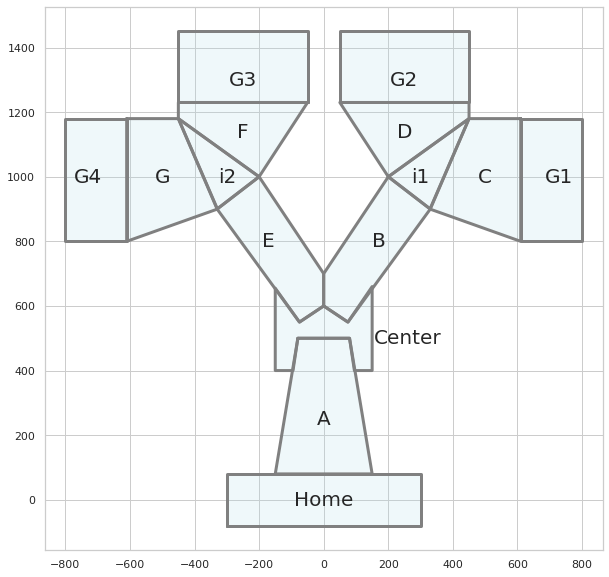

In [733]:
f,ax = plt.subplots(figsize=(10,10))
for zo in MazeZonesGeom.keys():
    pf.plotPoly(MazeZonesGeom[zo],ax,alpha=0.2,color='powderblue',lw=3)
ax.axis('equal')

ax.text(0,0,'Home',horizontalalignment='center',verticalalignment='center')
ax.text(0,250,'A',horizontalalignment='center',verticalalignment='center')
ax.text(155,500,'Center',horizontalalignment='left',verticalalignment='center')

ax.text(170,800,'B',horizontalalignment='center',verticalalignment='center')
ax.text(-170,800,'E',horizontalalignment='center',verticalalignment='center')

ax.text(300,1000,'i1',horizontalalignment='center',verticalalignment='center')
ax.text(-300,1000,'i2',horizontalalignment='center',verticalalignment='center')

ax.text(500,1000,'C',horizontalalignment='center',verticalalignment='center')
ax.text(-500,1000,'G',horizontalalignment='center',verticalalignment='center')

ax.text(730,1000,'G1',horizontalalignment='center',verticalalignment='center')
ax.text(-730,1000,'G4',horizontalalignment='center',verticalalignment='center')

ax.text(250,1140,'D',horizontalalignment='center',verticalalignment='center')
ax.text(-250,1140,'F',horizontalalignment='center',verticalalignment='center')

ax.text(250,1300,'G2',horizontalalignment='center',verticalalignment='center')
ax.text(-250,1300,'G3',horizontalalignment='center',verticalalignment='center')

In [535]:
class Points2D:
    def __init__(self, x, y, polar=False):

        if not isinstance(x, np.ndarray):
            x = np.array([x]).flatten()
        if not isinstance(y, np.ndarray):
            y = np.array([y]).flatten()

        assert len(x) == len(y), 'different lengths'

        self.n = len(x)
        if not polar:
            self.x = np.array(x)
            self.y = np.array(y)
            self.xy = np.column_stack((self.x, self.y))
            self.r, self.ang = self.polar()
        else:
            self.r = x
            self.ang = np.mod(y, 2 * np.pi)
            self.x, self.y = self.eu()
            self.xy = np.column_stack((self.x, self.y))

    def polar(self):
        r = np.sqrt(self.x ** 2 + self.y ** 2)
        ang = np.zeros(self.n)

        for ii in range(self.n):
            ang[ii] = np.math.atan2(self.y[ii], self.x[ii])
        ang = np.mod(ang, 2 * np.pi)
        return r, ang

    def eu(self):
        x = self.r * np.cos(self.ang)
        y = self.r * np.sin(self.ang)
        return x, y
    
    def half_ang(self):
        ang2 = np.array(self.ang)
        ang2[ang2>np.pi] = np.mod(ang2[ang2>np.pi], -np.pi)
        return ang2

    def __add__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(self.x + b, self.y + b)

        if isinstance(b, Points2D):
            return Points2D(self.x + b.x, self.y + b.y)
        else:
            raise NotImplementedError

    def __sub__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(self.x - b, self.y - b)

        if isinstance(b, Points2D):
            return Points2D(self.x - b.x, self.y - b.y)
        else:
            raise NotImplementedError

    def __rsub__(self, b):
        if isinstance(b, (int, float)):
            return Points2D(b - self.x, b - self.y)

        if isinstance(b, Points2D):
            return Points2D(b.x - self.x, b.y - self.y)
        else:
            raise NotImplementedError

    def __mul__(self, b):
        if isinstance(b, (int, float, np.float, np.int)):
            return Points2D(b * self.x, b * self.y)

        if isinstance(b, Points2D):
            return b.x @ self.x + b.y @ self.y
        else:
            raise NotImplementedError

    def __rmul__(self, b):
        if isinstance(b, (int, float, np.float, np.int)):
            return Points2D(b * self.x, b * self.y)
        elif isinstance(b, Points2D):
            if self.n == b.n:
                return Points2D(b.x * self.x, b.y @ self.y)
            if self.n == 1 or b.n == 1:
                return
        else:
            raise NotImplementedError
            
    def __truediv__(self,b):
        return Points2D(self.r/b, self.ang, polar=True)
    
    def __rdiv__(self,b):
        return Points2D(self.r/b, self.ang, polar=True)

    def __getitem__(self, i):
        if isinstance(i, (int, np.int, np.ndarray)):
            return Points2D(self.x[i], self.y[i])
        else:
            raise NotImplementedError

    def __len__(self):
        return self.n

    def __str__(self):
        print((self.x, self.y))
        return ''
    
    def _repr_html_(self):
        print(self.xy)
        return ''

def deg_full_2_half(th):
    th2 = np.array(th)
    th2[th>np.pi] = np.mod(th2[th>np.pi], -np.pi)
    return th2

In [196]:
b = Points2D(200,1000)
c = Points2D(330,900)
w = (b-c).r[0]

d = Points2D(75,550)
l = (c-d).r[0]
dc = c-d

wx = c.x-b.x
wy = b.y-c.y

a = Points2D(d.x-wx, d.y+wy)

n_SegB_subsegs = int(l//subseg_len_mm)
delta = l/n_SegB_subsegs

SegB =  MazeZonesGeom['SegB']
SegB_subsegs = np.zeros(n_SegB_subsegs,dtype=object)
for ii in range(n_SegB_subsegs):
    p0 = Points2D(ii*delta, dc.ang, polar=True)+a
    p1 = Points2D((ii+1)*delta, dc.ang, polar=True)+a
    p2 = Points2D((ii+1)*delta, dc.ang, polar=True)+d
    p3 = Points2D(ii*delta, dc.ang, polar=True)+d
    
    subseg = Polygon([p0.xy[0],
                      p1.xy[0], 
                      p2.xy[0], 
                      p3.xy[0]])
    SegB_subsegs[ii] = SegB.intersection(subseg)

In [736]:
def divide_seg(seg, subseg_length, orientation='v'):
    
    # bounding rectangle coords
    xx, yy = seg.minimum_rotated_rectangle.exterior.xy
    xx = xx[:4]
    yy = yy[:4]
    pp = Points2D(xx,yy)
    
    # center coords
    cc = np.array(seg.centroid.coords)[0]
    cp = Points2D(cc[0],cc[1])
    
    centered_pp = pp-cp
    coord_cen_ang = centered_pp.half_ang()
    min_ang_coord = np.argmin(np.abs(coord_cen_ang))
    
    if coord_cen_ang[min_ang_coord]<0:
        min_ang_coord+=1
    
    # circle coordinates to start at the min angle
    rpp = np.roll(pp.xy, -min_ang_coord, axis=0) 
    pp = Points2D(rpp[:,0], rpp[:,1])


    # 
    if orientation == 'v':
        L = pp[0]-pp[3]
        a = pp[2]
        b = pp[3]
    else:
        L = pp[1] - pp[0]
        a = pp[0]
        b = pp[3]
        
    n_subsegs = int(L.r//subseg_length)

    delta = L.r/n_subsegs
    subsegs = np.zeros(n_subsegs,dtype=object)
    
    for ii in range(n_subsegs):
        
        p0 = Points2D(ii*delta, L.ang, polar=True)+a
        p1 = Points2D((ii+1)*delta, L.ang, polar=True)+a
        p2 = Points2D((ii+1)*delta, L.ang, polar=True)+b
        p3 = Points2D(ii*delta, L.ang, polar=True)+b

        subseg = Polygon([p0.xy[0],
                          p1.xy[0], 
                          p2.xy[0], 
                          p3.xy[0]])
        
        subsegs[ii] = seg.intersection(subseg)
    return subsegs

def divide_seg2(seg, subseg_length, direction='N'):
    
    dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
    # bounding rectangle coords
    xx, yy = seg.minimum_rotated_rectangle.exterior.xy
    pp = Points2D(xx,yy)

    l_segs = np.diff(pp.xy,axis=0)
    l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

    l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
    l_segs_dirs[l_segs_dirs==5]=1
    
    l_dir_id = np.where(l_segs_dirs==dir_dict[direction])[0][0]

    L = l_segs[l_dir_id]
    L = Points2D(L[0], L[1])

    a = pp.xy[:4][l_dir_id-1]
    a = Points2D(a[0],a[1])
    b = pp.xy[:4][l_dir_id]
    b = Points2D(b[0],b[1])


    n_subsegs = int(L.r//subseg_length)

    delta = L.r/n_subsegs
    subsegs = np.zeros(n_subsegs,dtype=object)
    
    for ii in range(n_subsegs):
        
        p0 = Points2D(ii*delta, L.ang, polar=True)+a
        p1 = Points2D((ii+1)*delta, L.ang, polar=True)+a
        p2 = Points2D((ii+1)*delta, L.ang, polar=True)+b
        p3 = Points2D(ii*delta, L.ang, polar=True)+b

        subseg = Polygon([p0.xy[0],
                          p1.xy[0], 
                          p2.xy[0], 
                          p3.xy[0]])
        
        subsegs[ii] = seg.intersection(subseg)
    return subsegs

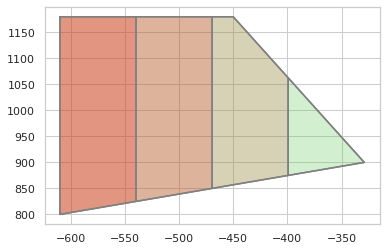

In [735]:
segName = 'SegG'
seg = MazeZonesGeom[segName]
subseg_length = 60

if segName[3] == 'C':
    d = 'E'
    sb = divide_seg2(seg, subseg_length, direction=d)
elif segName[3] == 'G':
    d='W'
    sb = divide_seg2(seg, subseg_length, direction=d)
else:
    d='N'
    sb = divide_seg2(seg, subseg_length, direction=d)
    
n_segs = len(sb)
    
f,ax=plt.subplots()
pf.plotPoly(seg,ax)    
for ii in range(n_segs):
    pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red')
    
dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
# bounding rectangle coords
xx, yy = seg.minimum_rotated_rectangle.exterior.xy

pp = Points2D(xx,yy)

l_segs = np.diff(pp.xy,axis=0)
l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
l_segs_dirs[l_segs_dirs==5]=1

l_dir_id = np.where(l_segs_dirs==dir_dict[d])[0][0]

L = l_segs[l_dir_id]
L = Points2D(L[0], L[1])

a = pp.xy[:4][l_dir_id-1]
a = Points2D(a[0],a[1])
b = pp.xy[:4][l_dir_id]
b = Points2D(b[0],b[1])

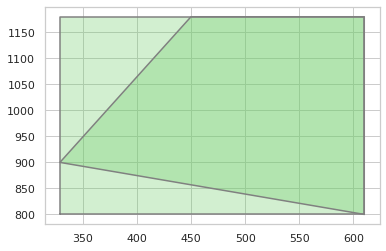

In [730]:
seg = Polygon([(610, 800),(610, 1180), (450, 1180), (329, 900)])

f,ax=plt.subplots()
pf.plotPoly(seg,ax)   
pf.plotPoly(seg.minimum_rotated_rectangle,ax)

In [685]:
direction = 'E'

dir_dict = {a:b for a,b in zip(['E','N','W','S'],range(1,5))}
# bounding rectangle coords
xx, yy = seg.minimum_rotated_rectangle.exterior.xy

pp = Points2D(xx,yy)

l_segs = np.diff(pp.xy,axis=0)
l_segs_v = Points2D(l_segs[:,0],l_segs[:,1])

l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi/4,2*np.pi +np.pi/4+0.001 ,np.pi/2 ))
l_segs_dirs[l_segs_dirs==5]=1

l_dir_id = np.where(l_segs_dirs==dir_dict[d])[0][0]

L = l_segs[l_dir_id]
L = Points2D(L[0], L[1])

a = pp.xy[:4][l_dir_id-1]
a = Points2D(a[0],a[1])
b = pp.xy[:4][l_dir_id]
b = Points2D(b[0],b[1])



In [690]:
l_segs_dirs, np.rad2deg(l_segs_v.ang), L.ang

(array([3, 4, 1, 2]),
 array([160.34617594, 250.34617594, 340.34617594,  70.34617594]),
 array([5.94016137]))

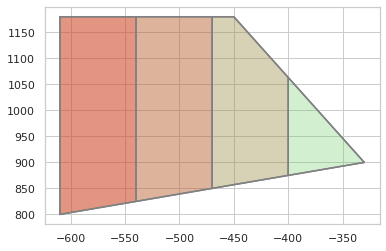

In [712]:

segName = 'SegG'

seg = MazeZonesGeom[segName]
if segName[3] == 'C':
    d = 'E'
    sb = divide_seg2(seg, subseg_length, direction=d)
elif segName[3] == 'G':
    d='W'
    sb = divide_seg2(seg, subseg_length, direction=d)
else:
    d='N'
    sb = divide_seg2(seg, subseg_length, direction=d)
    
n_segs = len(sb)
    
f,ax=plt.subplots()
pf.plotPoly(seg,ax)    
for ii in range(n_segs):
    pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red')
    

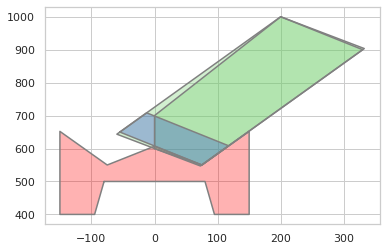

In [275]:
f,ax=plt.subplots()
pf.plotPoly(SegB,ax)
pf.plotPoly(subseg, ax, color='blue', alpha=0.3)
pf.plotPoly(MazeZonesGeom['Center'],ax, color='red')
pf.plotPoly(SegB.minimum_rotated_rectangle,ax)

(-880.0, 880.0, -156.5, 1526.5)

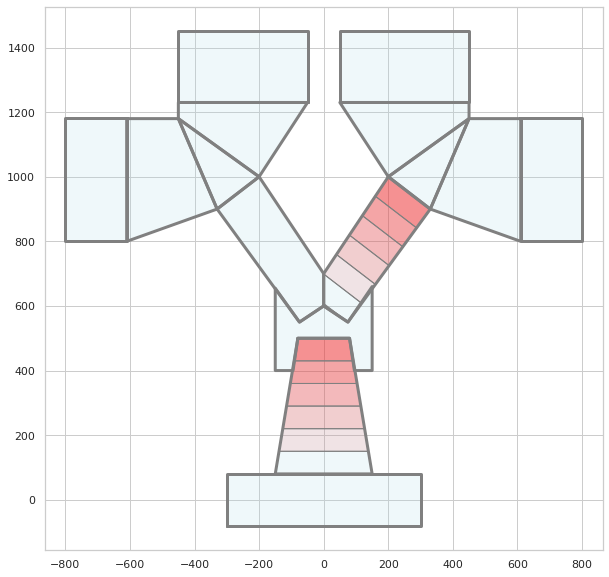

In [197]:
f,ax = plt.subplots(figsize=(10,10))
for zo in MazeZonesGeom.keys():
    pf.plotPoly(MazeZonesGeom[zo],ax,alpha=0.2,color='powderblue',lw=3)
    
    
    if zo == 'SegA':
        for ii in range(n_SegA_subsegs):
            pf.plotPoly(SegA_subsegs[ii],ax,alpha=0.5*ii/n_SegA_subsegs,color='red',lw=1)
    if zo == 'SegB':
        for ii in range(n_SegB_subsegs):
            pf.plotPoly(SegB_subsegs[ii],ax,alpha=0.5*ii/n_SegB_subsegs,color='red',lw=1)
ax.axis('equal')

## right upper corner correction for center

In [231]:
m=(c.y-d.y)/(c.x-d.x)
b = -m*c.x+c.y
int(b+m*150) 

652

## center correction

In [232]:
m=(a.y-d.y)/(a.x-d.x)
b = -m*a.x+a.y
int(b) 


607

## correction for sgments C and G
Change coords to start at 329 instead of 330 (error related to shapely min_rotated_rectanlge and creating subsegments).

# New Coordinates

In [770]:
MazeZonesCoords = {'Home': [(-300, -80), (-300, 80), (300, 80), (300, -80)],
                   'Center': [(-80, 500), (-95, 400), (-150, 400), (-150, 652),
                              (-75, 550), (0, 607), (75, 550), (150, 652), (150, 400),
                              (95, 400), (80, 500)],
                   'SegA': [(-150, 80), (-80, 500), (80, 500), (150, 80)],
                   'SegB': [(0, 607), (0, 700), (200, 1000), (329, 900), (75, 550)],
                   'SegC': [(610, 1180), (610, 800), (329, 900), (450, 1180)],
                   'SegD': [(200, 1000), (50, 1230), (450, 1230), (450, 1180)],
                   'SegE': [(0, 607), (0, 700), (-200, 1000), (-329, 900), (-75, 550)],
                   'SegF': [(-200, 1000), (-50, 1230), (-450, 1230), (-450, 1180)],
                   'SegG': [(-610, 1180), (-610, 800), (-329, 900), (-450, 1180)],

                   'G1': [(610, 1180), (800, 1180), (800, 800), (610, 800)],
                   'G2': [(50, 1230), (50, 1450), (450, 1450), (450, 1230)],
                   'G3': [(-50, 1230), (-50, 1450), (-450, 1450), (-450, 1230)],
                   'G4': [(-610, 1180), (-800, 1180), (-800, 800), (-610, 800)],

                   'I1': [(200, 1000), (450, 1180), (329, 900)],
                   'I2': [(-329, 900), (-450, 1180), (-200, 1000)],
                   }

ZonesNames = list(MazeZonesCoords.keys())
MazeZonesGeom = {}
for zo in ZonesNames:
    MazeZonesGeom[zo] = Polygon(MazeZonesCoords[zo])
    
out_dirs = {'SegA':'N', 
            'SegB':'N', 'SegC':'E', 'SegD':'N',
            'SegE':'N', 'SegF':'N', 'SegG':'W'}
in_dirs = {'SegA':'S', 
           'SegB':'S', 'SegC':'W', 'SegD':'S',
           'SegE':'S', 'SegF':'S', 'SegG':'E'}

In [1]:
plt.rcParams['lines.dash_capstyle'] = 'round'
plt.rcParams['lines.solid_capstyle'] = 'round'
f,ax = plt.subplots(figsize=(10,10))


for zo in MazeZonesGeom.keys():
    
    seg=MazeZonesGeom[zo]
    pf.plotPoly(seg,ax,alpha=0.2,color='powderblue',lw=2)
    
    if zo in out_dirs:
        sb = divide_seg2(seg, subseg_length, direction=out_dirs[zo])

        n_segs = len(sb)
        for ii in range(n_segs):
            #if zo=='SegG':
            pf.plotPoly(sb[ii],ax, alpha=0.5*ii/n_segs,color='red',lw=0)
        
ax.axis('equal')

NameError: name 'plt' is not defined

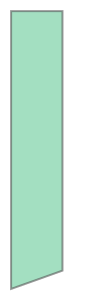

# test new tmf file.

In [7]:
import TreeMazeAnalyses2.Analyses.tree_maze_functions as tmf

In [8]:
si = reload(si)
session = 'Li_T3g_070618'
subject = session.split('_')[0]
session_info = si.SubjectSessionInfo(subject, session)

In [15]:
f_name = "/home/alexgonzalez/google-drive/TreeMazeProject/Figures/fig_1/TreeMazeLayout_plain.jpg"
img = plt.imread(f_name)

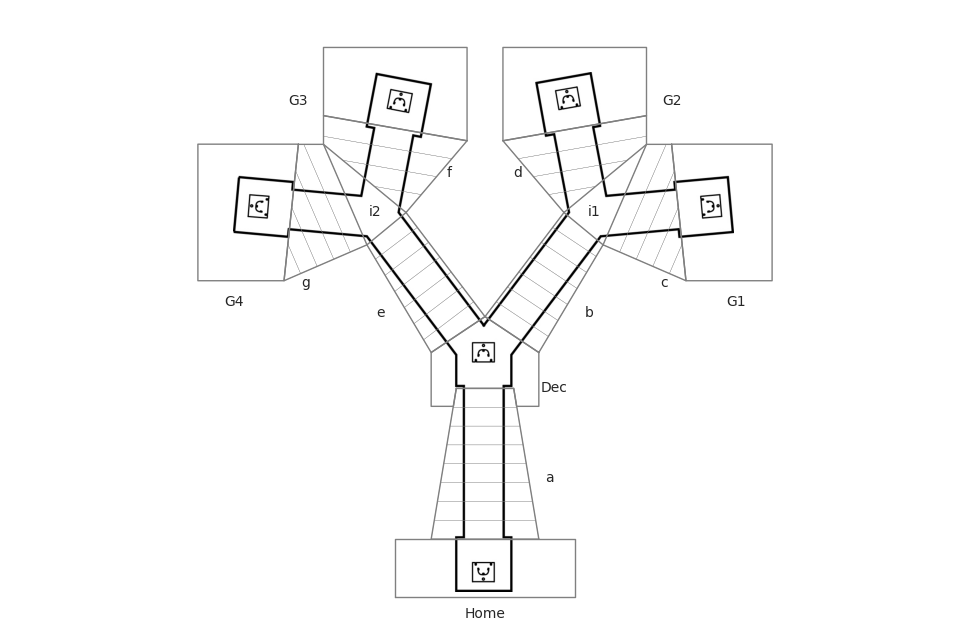

In [492]:
tmf = reload(tmf)
tree_maze = tmf.TreeMazeZones(sub_seg_length=50)

f,ax = plt.subplots(dpi=200)
ax = tree_maze.plot_maze(seg_color=None, zone_labels=True, seg_dir='in', font_size=5, lw=0.5, sub_segs='all', sub_seg_lw=0.1, sub_seg_color='None', tm_layout=True,axis=ax)


problem; the subsegments are cutting the goal segments at inconvenient angles.
make lines parallel to goals

In [44]:
g1 = tree_maze.zones_coords['G1']
# [(560, 1180.5), (800, 1180.5), (800, 800), (560, 800)]

In [68]:
from shapely.geometry.polygon import Polygon
from shapely.geometry.linestring import LineString

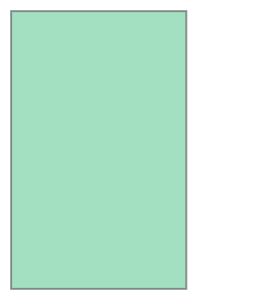

In [43]:
Polygon(g1)

In [46]:
h = 380.5
th = np.deg2rad(6)
a = h*np.arctan(th)
print(a)

39.701164795906315


In [55]:
segs = {'G1': [(520, 1180.5), (800, 1180.5), (800, 800), (560, 800)], 
        'c': [(520, 1180), (560, 800), (329, 900), (450, 1180)]}

In [56]:
tmf = reload(tmf)
tree_maze = tmf.TreeMazeZones(sub_seg_length=50)

In [60]:
def divide_seg(coords,  origin_line_coords, angle):

    
    p_max = np.asarray(coords).max(axis=0)
    p_min = np.asarray(coords).min(axis=0)
    for p in coords:
        max_x np,max
    
    # bounding rectangle coords
    seg_geom = Polygon(coords)
    xx, yy = seg_geom.minimum_rotated_rectangle.exterior.xy
    pp = Points2D(xx, yy)

    # get ccw line vectors for bounding rect
    l_segs = np.diff(pp.xy, axis=0)
    l_segs_v = Points2D(l_segs[:, 0], l_segs[:, 1])

    # get direction
    l_segs_dirs = np.digitize(l_segs_v.ang, np.arange(-np.pi / 4, 2 * np.pi + np.pi / 4 + 0.001, np.pi / 2))
    l_segs_dirs[l_segs_dirs == 5] = 1

    l_dir_id = np.where(l_segs_dirs == seg_dir_num)[0][0]

    L = l_segs[l_dir_id]
    L = Points2D(L[0], L[1])

    a = pp.xy[:4][l_dir_id - 1]
    a = Points2D(a[0], a[1])
    b = pp.xy[:4][l_dir_id]
    b = Points2D(b[0], b[1])

    n_subsegs = int(L.r // self.sub_seg_length)

    delta = L.r / n_subsegs
    sub_segs = np.zeros(n_subsegs, dtype=object)

    for ii in range(n_subsegs):
        p0 = Points2D(ii * delta, L.ang, polar=True) + a
        p1 = Points2D((ii + 1) * delta, L.ang, polar=True) + a
        p2 = Points2D((ii + 1) * delta, L.ang, polar=True) + b
        p3 = Points2D(ii * delta, L.ang, polar=True) + b

        sub_seg = Polygon([p0.xy[0],
                           p1.xy[0],
                           p2.xy[0],
                           p3.xy[0]])

        sub_segs[ii] = seg_geom.intersection(sub_seg)
    return sub_segs

TypeError: unhashable type: 'Polygon'

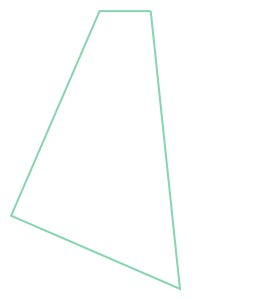

In [78]:
p_c = Polygon(segs['c'])
p_c.

In [464]:
def get_line_angle(p0,p1):
    return np.arctan2(p1[1]-p0[1], p1[0]-p0[0])

def sort_points_idx(points):
    points = np.asarray(points)
    
    idx = np.argsort(points[:,1])
    return idx
    
def extend_line(line_points, buffer):
    
    idx = sort_points_idx(line_points)
    sorted_points = line_points[idx]
    
    p0 = sorted_points[0]
    p1 = sorted_points[1]
    
    th = get_line_angle(p0,p1)
    wh = buffer*np.array((np.cos(th), np.sin(th)))
    
    out = np.array((p0 - wh, p1 + wh))

    if idx[0]==0:
        return out
    else:
        return out[::-1]

def project_line(line_points, l):
    p0 = line_points[0]
    p1 = line_points[1]
    
    th = get_line_angle(p0,p1)
    
    th_d = np.rad2deg(th)
    pi2 = np.pi/2
    
    if (th_d>=0) & (th_d<=180):
        wh = l*np.array((np.cos(pi2-th), -np.sin(pi2-th)))
    else:
        wh = l*np.array((np.cos(5*pi2-th), -np.sin(5*pi2-th)))

    out = np.array((p0 + wh, p1 + wh))
        
    return out
    
def plot_lines(lines,ax=None):
    if ax is None:
        f,ax = plt.subplots()
    
    lines = np.asarray(lines)
    if lines.ndim <= 1:
        print("invalid input")
        return None
    elif lines.ndim == 2:
        lines = lines[np.newaxis,]
    
    n_lines = lines.shape[0]
    
    for ii in range(n_lines):
        line = lines[ii]
        ax.plot(line[:,0], line[:,1])
        ax.scatter(line[0,0], line[0,1], color='k')
        ax.scatter(line[1,0], line[1,1], marker='d', color='k')

    return ax


def project_line_repeats(line_points, l, n_lines):
    l_s = np.arange(-n_lines*l, n_lines*l+1,l)
    
    n_l_s = len(l_s)
    lines = np.zeros((n_l_s, 2,2))
    
    for ii in range(n_l_s):
        lines[ii] = project_line(line_points, l_s[ii])
        
    return lines
        
    
def make_polygon_from_2_lines(line1, line2):
    
    coords = np.zeros((4,2), dtype=object)
    coords[0,:] = line1[0]
    coords[1,:] = line1[1]
    coords[2,:] = line2[1]
    coords[3,:] = line2[0]
            
    return Polygon(coords)

def make_polygon_from_lines(lines):
    n_lines = lines.shape[0]
    
    n_polygons = n_lines-1
    p = np.zeros(n_polygons, dtype=object)
    
    for ii in range(n_polygons):
        p[ii] = make_polygon_from_2_lines(lines[ii], lines[ii+1])
    
    return p


(-3.0, 3.0)

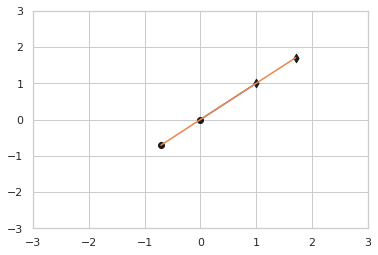

In [445]:
p0 = [0,0]
p1 = [1,1]

line1 = np.asarray( (p0,p1) )
line2 = extend_line(line1, 1)
lines = np.zeros( (2,2,2) )
lines[0] = line1
lines[1] = line2


ax = plot_lines(lines)
ax.set_xlim(-3,3)
ax.set_ylim(-3,3)

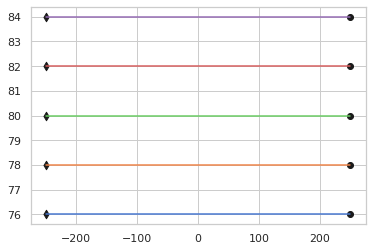

In [465]:
a = project_line_repeats(line2,2,2)
plot_lines(a)

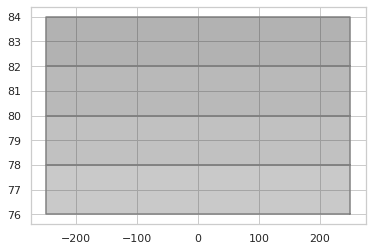

In [466]:
p = make_polygon_from_lines(a)

f,ax = plt.subplots()
for ii, pp in enumerate(p[::-1]):
    tmf.pf.plotPoly(pp,ax,color=f"{ii/10}")

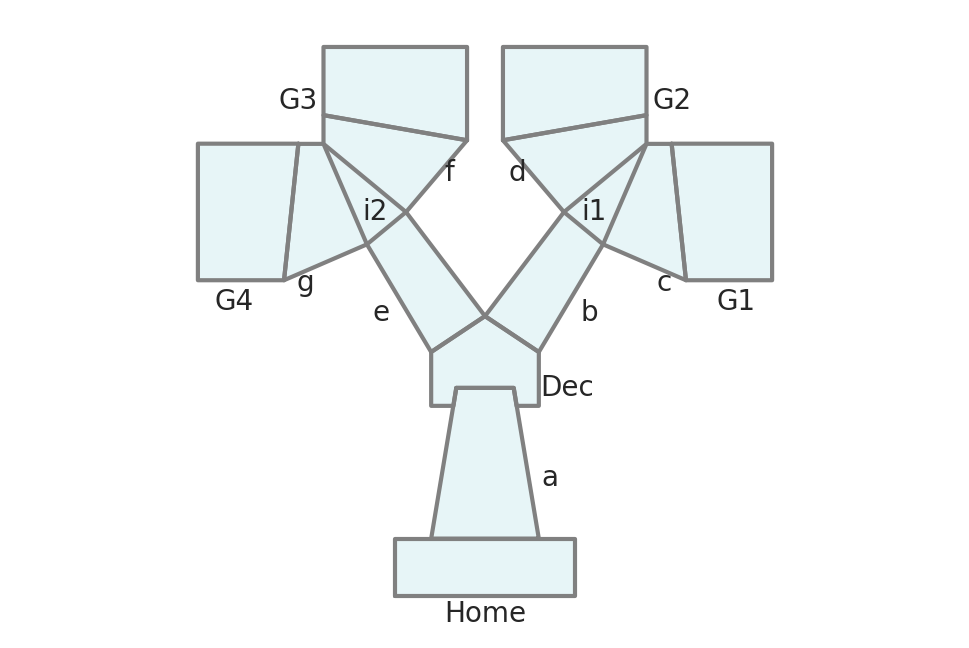

In [498]:
tmf = reload(tmf)
f,ax=plt.subplots(dpi=200)
tree_maze.plot_maze(axis=ax, zone_labels=True)

Segment A subs

In [467]:
line1 = np.array([(150, 80), (-150, 80)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,40)
p = make_polygon_from_lines(a)


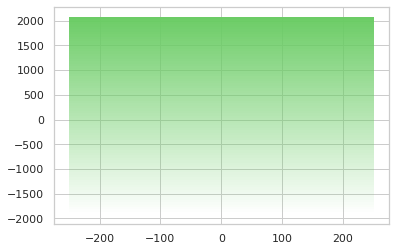

In [473]:

f,ax = plt.subplots()
for ii, pp in enumerate(p):
    tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)

Segment b

In [475]:
line1 = np.array([(150, 600), (0, 700)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,40)
p = make_polygon_from_lines(a)

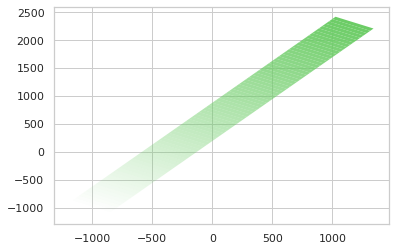

In [476]:
f,ax = plt.subplots()
for ii, pp in enumerate(p):
    tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)

segment c

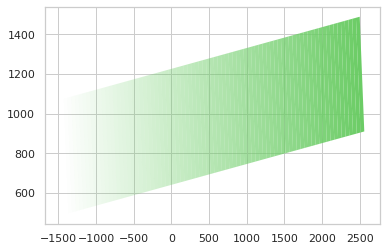

In [497]:
line1 = np.array([(560, 800), (520, 1180)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,40)
p = make_polygon_from_lines(a)

f,ax = plt.subplots()
for ii, pp in enumerate(p):
    tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)

seg e

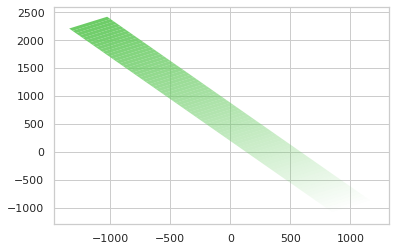

In [496]:
line1 = np.array([(0, 700),  (-150, 600)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,40)
p = make_polygon_from_lines(a)

f,ax = plt.subplots()
for ii, pp in enumerate(p):
    tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)

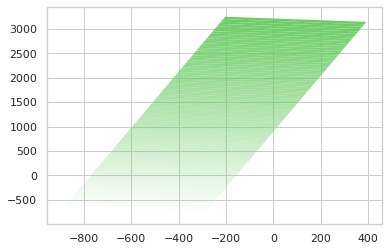

In [502]:
# seg f
line1 = np.array([(-50, 1190), (-450, 1260)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,40)
p = make_polygon_from_lines(a)

f,ax = plt.subplots()
for ii, pp in enumerate(p):
    tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)
    

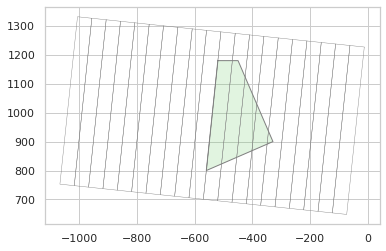

In [648]:
seg = 'g'

#line1 = np.array([(-520, 1180), (-560, 800)])
line1 = np.asarray(tree_maze.zones_coords[seg][slice(2)])
line2 = extend_line(line1, 100)

a = project_line_repeats(line2,50,10)
sub_polys = make_polygon_from_lines(a)

f,ax = plt.subplots()
# for ii, pp in enumerate(sub_polys):
#     tmf.pf.plotPoly(pp,ax,alpha=ii/len(p),lw=0)
    
tree_maze.plot_segs(sub_polys,lw=0.4, color='None', axis=ax)
tree_maze.plot_segs([tree_maze.zones_geom[seg]], color='g', alpha=0.2, axis=ax)

In [637]:
np.asarray(tree_maze.zones_coords['g'][slice(2)])

array([[-520, 1180],
       [-560,  800]])

a 16
b 16
c 9
d 9
e 16
f 9
g 9


(-616.0, 682.0, 21.0, 1319.0)

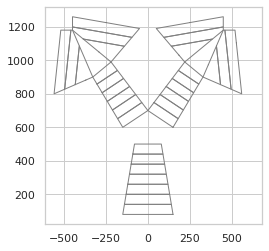

In [759]:
f,ax = plt.subplots()

for seg in tree_maze.linear_segs:

    seg_geom = tree_maze.zones_geom[seg]

    #line1 = np.array([(-520, 1180), (-560, 800)])
    line1 = np.asarray(tree_maze.zones_coords[seg][slice(2)])
    line2 = extend_line(line1, tree_maze.ext_length)

    a = project_line_repeats(line2,tree_maze.sub_seg_length,tree_maze.n_repeats)
    sub_polys = make_polygon_from_lines(a)

    intersecting_sub_segs = []
    cnt = -1
    union_sub_segs = Polygon()
    small_seg = Polygon()
    for ii, pp in enumerate(sub_polys):
        inter = seg_geom.intersection(pp)
        if inter.area >= 5000:
            intersecting_sub_segs.append(inter)    
            cnt += 1

            if small_seg.area > 0:
                intersecting_sub_segs[cnt] = intersecting_sub_segs[cnt].union(small_seg)
                small_seg = Polygon()

        elif (inter.area > 1): 
            if cnt>0:
                intersecting_sub_segs[cnt] = intersecting_sub_segs[cnt].union(inter)
            else:
                small_seg = inter
        else:
            continue

        union_sub_segs = union_sub_segs.union(inter)

        if seg_geom.difference(union_sub_segs).area < 1:
            print(seg, ii)
            break
        
    tree_maze.plot_segs(intersecting_sub_segs, axis=ax)

ax.axis("square")

a 16
b 16
c 9
d 9
e 16
f 9
g 9


(-616.0, 682.0, 21.0, 1319.0)

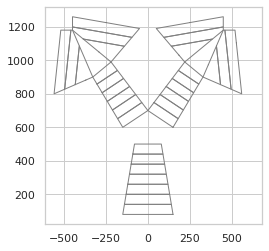

In [766]:
f,ax = plt.subplots()

for seg in tree_maze.linear_segs:

    seg_geom = tree_maze.zones_geom[seg]

    #line1 = np.array([(-520, 1180), (-560, 800)])
    line = np.asarray(tree_maze.zones_coords[seg][slice(2)])
    e_line = tree_maze._poly_funcs.extend_line(line, tree_maze.ext_length)

    lines = tree_maze._poly_funcs.project_line_repeats(e_line, tree_maze.sub_seg_length,tree_maze.n_repeats)
    #a = project_line_repeats(line2,tree_maze.sub_seg_length,tree_maze.n_repeats)
    sub_polys = tree_maze._poly_funcs.make_poly_sequence_from_parallel_lines(lines)
    #sub_polys = make_polygon_from_lines(lines)

    intersecting_sub_segs = []
    cnt = -1
    union_sub_segs = Polygon()
    small_seg = Polygon()
    for ii, pp in enumerate(sub_polys):
        inter = seg_geom.intersection(pp)
        if inter.area >= 5000:
            intersecting_sub_segs.append(inter)    
            cnt += 1

            if small_seg.area > 0:
                intersecting_sub_segs[cnt] = intersecting_sub_segs[cnt].union(small_seg)
                small_seg = Polygon()

        elif (inter.area > 1): 
            if cnt>0:
                intersecting_sub_segs[cnt] = intersecting_sub_segs[cnt].union(inter)
            else:
                small_seg = inter
        else:
            continue

        union_sub_segs = union_sub_segs.union(inter)

        if seg_geom.difference(union_sub_segs).area < 1:
            print(seg, ii)
            break
        
    tree_maze.plot_segs(intersecting_sub_segs, axis=ax)

ax.axis("square")

In [763]:
lines.shape

(1201, 2, 2)

In [715]:
seg_geom.difference(union_sub_segs).area

1.0658141036401503e-12

In [745]:
tree_maze.sub_segs

{'a': [], 'b': [], 'c': [], 'd': [], 'e': [], 'f': [], 'g': []}

In [746]:
tree_maze.divide_segs()

{'a': [], 'b': [], 'c': [], 'd': [], 'e': [], 'f': [], 'g': []}

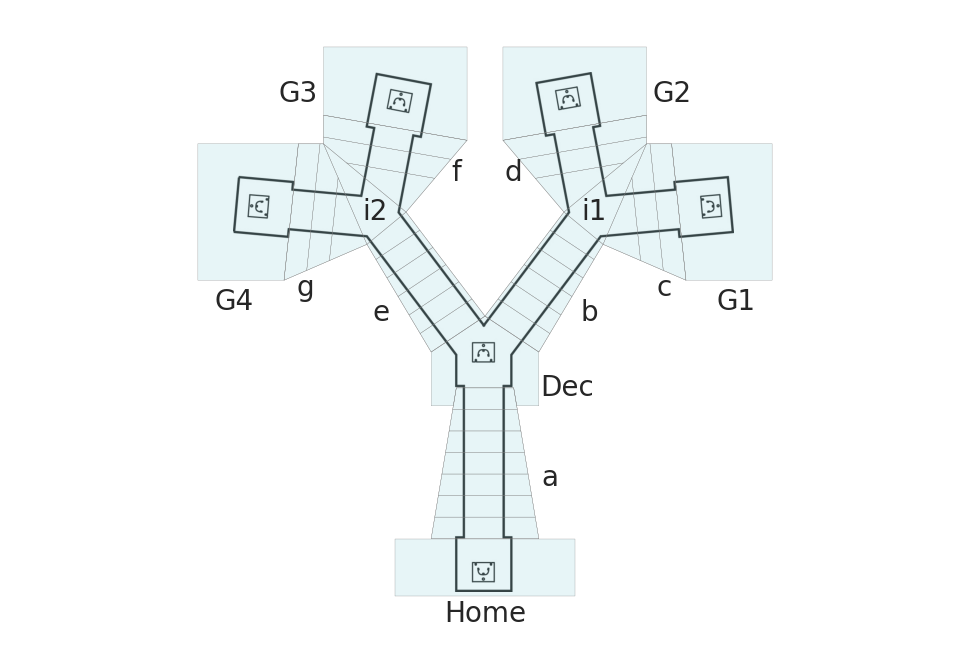

In [774]:
tmf = reload(tmf)
tree_maze = tmf.TreeMazeZones()
f,ax=plt.subplots(dpi=200)
tree_maze.plot_maze(axis=ax, zone_labels=True, sub_segs='all', lw=0.1, tm_layout=True)

## check process for other 